# Import libraries

In [1]:
import numpy as np
import pandas as pd

import gc
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import f1_score

%matplotlib inline

In [2]:
df_train = pd.read_csv("train_npf2.csv", delimiter=",", encoding="cp1251")
df_train

,Unnamed: 0,index,product_rk,store_location_rk,date,demand,PRODUCT_RK,STORE_LOCATION_RK,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,43,43,19540,309,2016-12-26,1.000000,19540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44,44,19540,355,2016-12-19,1.000000,19540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45,45,19540,355,2017-01-02,0.027027,19540,355.0,1.0,0.0,2849.000000,1709.40,0.0,1.0
3,46,46,19540,355,2017-03-27,1.000000,19540,355.0,0.0,0.0,2856.142857,1782.02,0.0,1.0
4,47,47,19540,355,2018-01-01,0.002740,19540,355.0,1.0,0.0,2899.000000,2217.74,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193901,209593,209593,98432,1316,2019-11-25,NaN,98432,1316.0,1.0,0.0,2049.000000,1024.50,0.0,1.0
193902,209594,209594,98445,1316,2019-11-25,NaN,98445,1316.0,1.0,0.0,3299.000000,989.70,0.0,1.0
193903,209595,209595,98470,1316,2019-11-25,NaN,98470,1316.0,1.0,0.0,3049.000000,914.70,0.0,1.0
193904,209596,209596,98475,1316,2019-11-25,NaN,98475,1316.0,1.0,0.0,3049.000000,914.70,0.0,1.0


In [3]:
sample_sub = pd.read_csv("sample_npf2.csv", delimiter=",", index_col=None)

In [4]:
df_test = df_train[df_train['index'].isin(sample_sub['index'])]
df_train = df_train[~df_train['index'].isin(sample_sub['index'])]

df_test = df_test.drop(columns='demand')

In [5]:
df_train = df_train.rename(columns={'date': 'period_dt', 'PRODUCT_RK': 'PRODUCT_ID', 'STORE_LOCATION_RK': 'STORE_LOCATION_ID'})
df_test = df_test.rename(columns={'date': 'period_dt', 'PRODUCT_RK': 'PRODUCT_ID', 'STORE_LOCATION_RK': 'STORE_LOCATION_ID'})

In [6]:
df_train.head()

,Unnamed: 0,index,product_rk,store_location_rk,period_dt,demand,PRODUCT_ID,STORE_LOCATION_ID,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
0,43,43,19540,309,2016-12-26,1.000000,19540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,44,44,19540,355,2016-12-19,1.000000,19540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,45,45,19540,355,2017-01-02,0.027027,19540,355.0,1.0,0.0,2849.000000,1709.40,0.0,1.0
3,46,46,19540,355,2017-03-27,1.000000,19540,355.0,0.0,0.0,2856.142857,1782.02,0.0,1.0
4,47,47,19540,355,2018-01-01,0.002740,19540,355.0,1.0,0.0,2899.000000,2217.74,0.0,1.0


In [7]:
df_test.head()

,Unnamed: 0,index,product_rk,store_location_rk,period_dt,PRODUCT_ID,STORE_LOCATION_ID,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG
817,902,902,19544,1363,2019-11-04,19544,1363.0,1.0,0.0,2999.0,899.700000,0.0,1.0
1039,1163,1163,19545,1380,2019-11-04,19545,1380.0,1.0,0.0,2999.0,2142.142857,0.0,1.0
1043,1167,1167,19545,1380,2019-11-18,19545,1380.0,1.0,0.0,2999.0,1499.500000,0.0,1.0
1048,1172,1172,19545,1380,2019-11-25,19545,1380.0,1.0,0.0,2999.0,1499.500000,0.0,1.0
1065,1202,1202,135955,1326,2019-11-04,135955,1326.0,1.0,0.0,2999.0,1499.500000,4.0,1.0


# Data analysis:

In [8]:
df_agg = df_train.agg(
    [
        "nunique",
        (lambda x: x.nunique() / len(x) * 100),
        (lambda x: x.isna().sum()),
        (lambda x: x.isna().sum() / len(x) * 100),
        (lambda x: x.isin([0]).sum()),
        (lambda x: x.isin([0]).sum() / len(x) * 100),
    ]
).transpose()

df_agg.columns = [
    "Unique",
    "Percentage of unique",
    "NaNs",
    "Percentage of NaNs",
    "Null values",
    "Percentage of nulls",
]
df_agg

,Unique,Percentage of unique,NaNs,Percentage of NaNs,Null values,Percentage of nulls
Unnamed: 0,193378.0,100.000000,0.0,0.000000,0.0,0.000000
index,193378.0,100.000000,0.0,0.000000,0.0,0.000000
product_rk,894.0,0.462307,0.0,0.000000,0.0,0.000000
store_location_rk,41.0,0.021202,0.0,0.000000,0.0,0.000000
period_dt,151.0,0.078085,0.0,0.000000,0.0,0.000000
demand,17306.0,8.949312,6105.0,3.157029,2238.0,1.157319
PRODUCT_ID,894.0,0.462307,0.0,0.000000,0.0,0.000000
STORE_LOCATION_ID,40.0,0.020685,1665.0,0.861008,0.0,0.000000
PROMO1_FLAG,3.0,0.001551,1665.0,0.861008,81324.0,42.054422
PROMO2_FLAG,2.0,0.001034,1665.0,0.861008,190954.0,98.746496


In [9]:
df_agg = df_test.agg(
    [
        "nunique",
        (lambda x: x.nunique() / len(x) * 100),
        (lambda x: x.isna().sum()),
        (lambda x: x.isna().sum() / len(x) * 100),
        (lambda x: x.isin([0]).sum()),
        (lambda x: x.isin([0]).sum() / len(x) * 100),
    ]
).transpose()

df_agg.columns = [
    "Unique",
    "Percentage of unique",
    "NaNs",
    "Percentage of NaNs",
    "Null values",
    "Percentage of nulls",
]
df_agg

,Unique,Percentage of unique,NaNs,Percentage of NaNs,Null values,Percentage of nulls
Unnamed: 0,528.0,100.000000,0.0,0.000000,0.0,0.000000
index,528.0,100.000000,0.0,0.000000,0.0,0.000000
product_rk,161.0,30.492424,0.0,0.000000,0.0,0.000000
store_location_rk,33.0,6.250000,0.0,0.000000,0.0,0.000000
period_dt,4.0,0.757576,0.0,0.000000,0.0,0.000000
PRODUCT_ID,161.0,30.492424,0.0,0.000000,0.0,0.000000
STORE_LOCATION_ID,33.0,6.250000,0.0,0.000000,0.0,0.000000
PROMO1_FLAG,1.0,0.189394,0.0,0.000000,0.0,0.000000
PROMO2_FLAG,2.0,0.378788,0.0,0.000000,485.0,91.856061
PRICE_REGULAR,44.0,8.333333,74.0,14.015152,0.0,0.000000


In [10]:
df_train = df_train.fillna({'demand': 0.5, 'STORE_LOCATION_ID': -1, 'NUM_CONSULTANT': 0, 'AUTORIZATION_FLAG': 0, 'PROMO1_FLAG': 0,
                           'PROMO2_FLAG': 0, 'PRICE_REGULAR': 0, 'PRICE_AFTER_DISC': 0})
df_test = df_test.fillna({'STORE_LOCATION_ID': -1, 'NUM_CONSULTANT': 0, 'AUTORIZATION_FLAG': 0, 'PROMO1_FLAG': 0,
                           'PROMO2_FLAG': 0, 'PRICE_REGULAR': 0, 'PRICE_AFTER_DISC': 0})

# Graphs

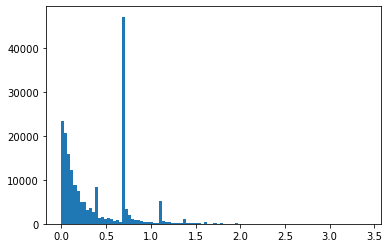

In [11]:
hist = plt.hist(np.log1p(df_train.demand.values), bins=100)
plt.show()

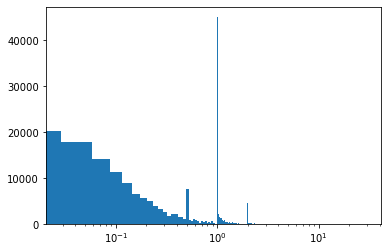

In [12]:
hist = plt.hist((df_train.demand.values), bins=1000)
plt.xscale('log')
plt.show()

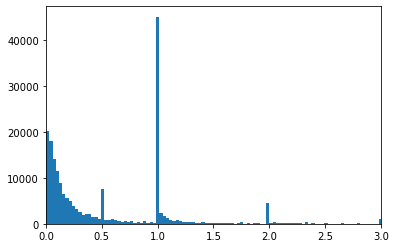

In [13]:
hist = plt.hist((df_train.demand.values), bins=1000)
plt.xlim((0, 3))
plt.show()

# Get df for a submission

In [14]:
sub = sample_sub.copy()

In [15]:
sub.demand = 0

# Data preprocesssing and model

In [16]:
df_train.period_dt = pd.to_datetime(df_train.period_dt)
df_train["day"] = df_train.period_dt.dt.day
df_train["weekday"] = df_train.period_dt.dt.weekday
df_train["year"] = df_train.period_dt.dt.year
df_train["month"] = df_train.period_dt.dt.month
df_train["dayofyear"] = df_train.period_dt.dt.dayofyear

In [17]:
df_test.period_dt = pd.to_datetime(df_test.period_dt)
df_test["day"] = df_test.period_dt.dt.day
df_test["weekday"] = df_test.period_dt.dt.weekday
df_test["year"] = df_test.period_dt.dt.year
df_test["month"] = df_test.period_dt.dt.month
df_test["dayofyear"] = df_test.period_dt.dt.dayofyear

In [18]:
df_train["flag"] = 0

In [19]:
df_train_low = df_train[df_train["demand"] <= 1]

df_train.loc[df_train["demand"] <= 5, "flag"] = 1

In [20]:
df_train_low

,Unnamed: 0,index,product_rk,store_location_rk,period_dt,demand,PRODUCT_ID,STORE_LOCATION_ID,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,day,weekday,year,month,dayofyear,flag
0,43,43,19540,309,2016-12-26,1.000000,19540,-1.0,0.0,0.0,0.000000,0.00,0.0,0.0,26,0,2016,12,361,0
1,44,44,19540,355,2016-12-19,1.000000,19540,-1.0,0.0,0.0,0.000000,0.00,0.0,0.0,19,0,2016,12,354,0
2,45,45,19540,355,2017-01-02,0.027027,19540,355.0,1.0,0.0,2849.000000,1709.40,0.0,1.0,2,0,2017,1,2,0
3,46,46,19540,355,2017-03-27,1.000000,19540,355.0,0.0,0.0,2856.142857,1782.02,0.0,1.0,27,0,2017,3,86,0
4,47,47,19540,355,2018-01-01,0.002740,19540,355.0,1.0,0.0,2899.000000,2217.74,0.0,1.0,1,0,2018,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193884,209576,209576,137670,1347,2019-09-16,0.000000,137670,1347.0,0.0,0.0,0.000000,0.00,0.0,1.0,16,0,2019,9,259,0
193885,209577,209577,137670,1316,2019-09-23,0.000000,137670,1316.0,0.0,0.0,0.000000,0.00,0.0,1.0,23,0,2019,9,266,0
193886,209578,209578,137670,1326,2019-09-23,0.000000,137670,1326.0,0.0,0.0,0.000000,0.00,0.0,1.0,23,0,2019,9,266,0
193887,209579,209579,98447,1316,2019-09-23,1.000000,98447,1316.0,1.0,0.0,3299.000000,0.00,0.0,1.0,23,0,2019,9,266,0


In [21]:
df_train.PRODUCT_ID.value_counts()

20971    1808
20727    1566
20725    1485
21271    1452
20726    1402
         ... 
98553       1
98428       1
98505       1
98495       1
98395       1
Name: PRODUCT_ID, Length: 894, dtype: int64

In [22]:
df_train.STORE_LOCATION_ID.value_counts() 

 1281.0    13563
 525.0     12396
 1326.0    10684
 764.0     10582
 1034.0     9852
 1316.0     9494
 557.0      9131
 425.0      8824
 1328.0     8598
 1347.0     7795
 657.0      7245
 1363.0     7184
 798.0      6817
 453.0      5902
 1005.0     5834
 1162.0     4986
 562.0      4615
 862.0      4286
 874.0      3940
 866.0      3804
 355.0      3675
 1191.0     3154
 1203.0     2753
 1080.0     2574
 644.0      2253
 1079.0     2086
 517.0      2017
 555.0      1870
 380.0      1793
 1143.0     1669
 1185.0     1668
-1.0        1665
 535.0      1509
 637.0      1388
 540.0      1375
 504.0      1186
 1173.0     1152
 1202.0     1076
 317.0      1072
 533.0       992
 1380.0      919
Name: STORE_LOCATION_ID, dtype: int64

In [23]:
df_first = df_train.groupby(by=["PRODUCT_ID", "STORE_LOCATION_ID"])["period_dt"].min().reset_index()
df_first

,PRODUCT_ID,STORE_LOCATION_ID,period_dt
0,19540,-1.0,2016-12-19
1,19540,355.0,2017-01-02
2,19540,380.0,2018-02-26
3,19540,425.0,2016-12-26
4,19540,453.0,2017-01-02
...,...,...,...
14939,140615,1316.0,2019-07-15
14940,140615,1326.0,2019-07-15
14941,140615,1328.0,2019-07-15
14942,140615,1347.0,2019-07-15


# Create pairs

In [24]:
pairs = list(zip(df_first["PRODUCT_ID"], df_first["STORE_LOCATION_ID"]))

In [25]:
df_train1 = df_train[df_train[["PRODUCT_ID", "STORE_LOCATION_ID"]].apply(tuple, axis = 1).isin(pairs)]

# Dates cleaning

In [26]:
df_train = df_train.drop(columns = "period_dt")
df_test = df_test.drop(columns = "period_dt")

# Model

In [27]:
y = df_train["flag"]
X = df_train.drop(columns=["flag", "demand"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=808, stratify=y)

In [28]:
features = np.array(X_train.columns)
categorical = features

In [29]:
numeric = []

In [30]:
xgb_flags = xgb.XGBClassifier(n_estimators=350, learning_rate=0.22, max_depth=6)

In [31]:
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric),
    ]
)

pipeline = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        (
            "classifier",
            xgb_flags,
        ),
    ]
)

In [32]:
model_flags = pipeline
model_flags.fit(X_train, y_train)
y_temp = model_flags.predict(X_test)
accuracy_score(y_test, y_temp)

c:\users\pipek\downloads\wpy64-3810\python-3.8.1.amd64\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:11:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9976729754886752

In [33]:
f1_score(y_test, y_temp)

0.9988348609600746

### Make smape score

In [34]:
def my_smape(A, F):
    A = A
    F = F
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

smape = make_scorer(my_smape, greater_is_better=False)

### XGBoost

In [35]:
df_train.columns

Index(['Unnamed: 0', 'index', 'product_rk', 'store_location_rk', 'demand',
       'PRODUCT_ID', 'STORE_LOCATION_ID', 'PROMO1_FLAG', 'PROMO2_FLAG',
       'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'NUM_CONSULTANT',
       'AUTORIZATION_FLAG', 'day', 'weekday', 'year', 'month', 'dayofyear',
       'flag'],
      dtype='object')

In [36]:
y = df_train["demand"]
X = df_train.drop(columns=["demand", "flag"])

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=707)

In [38]:
features = np.array(X_train.columns)

numeric = []

categorical = features

In [39]:
categorical

array(['Unnamed: 0', 'index', 'product_rk', 'store_location_rk',
       'PRODUCT_ID', 'STORE_LOCATION_ID', 'PROMO1_FLAG', 'PROMO2_FLAG',
       'PRICE_REGULAR', 'PRICE_AFTER_DISC', 'NUM_CONSULTANT',
       'AUTORIZATION_FLAG', 'day', 'weekday', 'year', 'month',
       'dayofyear'], dtype=object)

In [40]:
args = {'eval_metric': 'mape', 'eta': 0.24, 'n_estimators': 330, 'max_depth': 4}
xgb_cool = xgb.XGBRegressor(**args)

In [41]:
column_transformer = ColumnTransformer(
    [
        ("ohe", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("scaling", StandardScaler(), numeric),
    ]
)

pipeline = Pipeline(
    steps=[
        ("ohe_and_scaling", column_transformer),
        (
            "GBRegressor",
            xgb_cool,
        ),
    ]
)

In [42]:
model = pipeline.fit(X, y)
y_pred = model.predict(X_test)

In [43]:
my_smape(y_test, y_pred)

84.86900301004243

# Make a prediction

In [44]:
y_flags = model_flags.predict(df_test)
df_test["flags"] = y_flags

In [45]:
df_test.head(3)

,Unnamed: 0,index,product_rk,store_location_rk,PRODUCT_ID,STORE_LOCATION_ID,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,day,weekday,year,month,dayofyear,flags
817,902,902,19544,1363,19544,1363.0,1.0,0.0,2999.0,899.700000,0.0,1.0,4,0,2019,11,308,1
1039,1163,1163,19545,1380,19545,1380.0,1.0,0.0,2999.0,2142.142857,0.0,1.0,4,0,2019,11,308,1
1043,1167,1167,19545,1380,19545,1380.0,1.0,0.0,2999.0,1499.500000,0.0,1.0,18,0,2019,11,322,1


In [46]:
y_preds = model.predict(df_test.drop(columns="flags"))

In [47]:
df_test["demand"] = y_preds

In [48]:
#df_test.loc[df_test["flags"] == 1, "demand"] = 0

In [49]:
#df_test.loc[df_test["flags"] == 0, "demand"] = 1

Check results

In [50]:
sub = df_test[["index", "demand"]].copy()

In [51]:
sub

,index,demand
817,902,0.609794
1039,1163,0.656663
1043,1167,0.657309
1048,1172,0.648557
1065,1202,0.687834
...,...,...
193901,209593,0.406032
193902,209594,0.543910
193903,209595,0.520087
193904,209596,0.520087


In [52]:
sub.demand.value_counts()

0.194442    22
0.447193    12
0.458308    12
0.197451    11
0.455299     9
            ..
0.410304     1
0.807887     1
0.565438     1
1.168142     1
0.823297     1
Name: demand, Length: 309, dtype: int64

In [53]:
C = 0.28
sub['demand'] = sub.demand.apply(lambda x: 0 if x < C else 1)

In [54]:
sub.demand.value_counts()

1    458
0     70
Name: demand, dtype: int64

In [55]:
sub.to_csv("only_0_and_1_" + str(C) + ".csv", index=None)

In [56]:
df_test

,Unnamed: 0,index,product_rk,store_location_rk,PRODUCT_ID,STORE_LOCATION_ID,PROMO1_FLAG,PROMO2_FLAG,PRICE_REGULAR,PRICE_AFTER_DISC,NUM_CONSULTANT,AUTORIZATION_FLAG,day,weekday,year,month,dayofyear,flags,demand
817,902,902,19544,1363,19544,1363.0,1.0,0.0,2999.0,899.700000,0.0,1.0,4,0,2019,11,308,1,0.609794
1039,1163,1163,19545,1380,19545,1380.0,1.0,0.0,2999.0,2142.142857,0.0,1.0,4,0,2019,11,308,1,0.656663
1043,1167,1167,19545,1380,19545,1380.0,1.0,0.0,2999.0,1499.500000,0.0,1.0,18,0,2019,11,322,1,0.657309
1048,1172,1172,19545,1380,19545,1380.0,1.0,0.0,2999.0,1499.500000,0.0,1.0,25,0,2019,11,329,1,0.648557
1065,1202,1202,135955,1326,135955,1326.0,1.0,0.0,2999.0,1499.500000,4.0,1.0,4,0,2019,11,308,1,0.687834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193901,209593,209593,98432,1316,98432,1316.0,1.0,0.0,2049.0,1024.500000,0.0,1.0,25,0,2019,11,329,1,0.406032
193902,209594,209594,98445,1316,98445,1316.0,1.0,0.0,3299.0,989.700000,0.0,1.0,25,0,2019,11,329,1,0.543910
193903,209595,209595,98470,1316,98470,1316.0,1.0,0.0,3049.0,914.700000,0.0,1.0,25,0,2019,11,329,1,0.520087
193904,209596,209596,98475,1316,98475,1316.0,1.0,0.0,3049.0,914.700000,0.0,1.0,25,0,2019,11,329,1,0.520087


In [57]:
sub

,index,demand
817,902,1
1039,1163,1
1043,1167,1
1048,1172,1
1065,1202,1
...,...,...
193901,209593,1
193902,209594,1
193903,209595,1
193904,209596,1


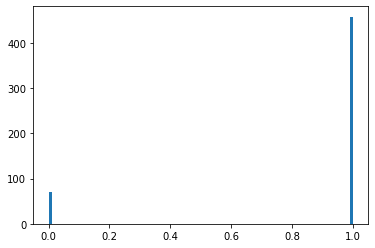

In [58]:
hist = plt.hist((sub.demand.values), bins=100)
plt.show()